In [ ]:
%system nvcc --version

['nvcc: NVIDIA (R) Cuda compiler driver',
 'Copyright (c) 2005-2024 NVIDIA Corporation',
 'Built on Thu_Jun__6_02:18:23_PDT_2024',
 'Cuda compilation tools, release 12.5, V12.5.82',
 'Build cuda_12.5.r12.5/compiler.34385749_0']

In [1]:
%cd '/content'
import os

main_path = os.getcwd() # %cd {main_path}

!git clone https://github.com/RuiZhang97/ISNet.git
%cd ISNet
!git checkout master
%pip install -r requirements.txt
#%cd '/content/ISNet/model'
#!rm -rf DCNv2
#!git clone https://github.com/lucasjinreal/DCNv2_latest DCNv2

%pip uninstall -y torch torchvision torchaudio
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
#%pip install ninja cmake
#
#%cd DCNv2
#!python setup.py build develop

/content
fatal: destination path 'ISNet' already exists and is not an empty directory.
/content/ISNet
M	model/ISNet.py
M	model/train_ISNet.py
M	model/utils1/dataset_IRSTD1K.py
M	sirst-master/README.md
Already on 'master'
Your branch is up to date with 'origin/master'.
  Using cached numpy-1.22.4.zip (11.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement torchvision~=0.13.0 (from versions: 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.

In [3]:
%%writefile /content/ISNet/model/utils/TTOA.py
import math

import torch
import torch.nn as nn
from torch.nn.modules.utils import _pair
from torchvision.ops.deform_conv import deform_conv2d


class DCNv2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation=1):
        super(DCNv2, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _pair(padding)
        self.dilation = _pair(dilation)

        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, *self.kernel_size))
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1.0 / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()


class DCN(DCNv2):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation=1):
        super(DCN, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation)

        channels_ = 3 * self.kernel_size[0] * self.kernel_size[1]
        self.conv_offset_mask = nn.Conv2d(
            self.in_channels,
            channels_,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding,
            bias=True,
        )
        self.init_offset()

    def init_offset(self):
        self.conv_offset_mask.weight.data.zero_()
        self.conv_offset_mask.bias.data.zero_()

    def forward(self, input):
        out = self.conv_offset_mask(input)
        o1, o2, mask = torch.chunk(out, 3, dim=1)
        offset = torch.cat((o1, o2), dim=1)
        mask = torch.sigmoid(mask)
        return deform_conv2d(input, offset, self.weight, self.bias, self.stride, self.padding, self.dilation, mask)


class TTOA(nn.Module):
    def __init__(self, low_channels, high_channels, c_kernel=3, r_kernel=3, use_att=False, use_process=True):
        """
        :param low_channels: low_level feature channels
        :param high_channels: high_level feature channels
        :param c_kernel: colum dcn kernels kx1 just use k
        :param r_kernel: row dcn kernels 1xk just use k
        :param use_att: bools
        :param use_process: bools
        """
        super(TTOA, self).__init__()

        self.l_c = low_channels
        self.h_c = high_channels
        self.c_k = c_kernel
        self.r_k = r_kernel
        self.att = use_att
        self.non_local_att = nn.Conv2d
        if self.l_c == self.h_c:
            print("Channel checked!")
        else:
            raise ValueError("Low and Hih channels need to be the same!")
        self.dcn_row = DCN(self.l_c, self.h_c, kernel_size=(1, self.r_k), stride=1, padding=(0, self.r_k // 2))
        self.dcn_colum = DCN(self.l_c, self.h_c, kernel_size=(self.c_k, 1), stride=1, padding=(self.c_k // 2, 0))
        self.sigmoid = nn.Sigmoid()
        if self.att is True:
            self.csa = self.non_local_att(self.l_c, self.h_c, 1, 1, 0)
        else:
            self.csa = None
        if use_process is True:
            self.preprocess = nn.Sequential(
                nn.Conv2d(self.l_c, self.h_c // 2, 1, 1, 0), nn.Conv2d(self.h_c // 2, self.l_c, 1, 1, 0)
            )
        else:
            self.preprocess = None

    def forward(self, a_low, a_high):
        if self.preprocess is not None:
            a_low = self.preprocess(a_low)
            a_high = self.preprocess(a_high)
        else:
            a_low = a_low
            a_high = a_high

        a_low_c = self.dcn_colum(a_low)
        a_low_cw = self.sigmoid(a_low_c)
        a_low_cw = a_low_cw * a_high
        a_colum = a_low + a_low_cw

        a_low_r = self.dcn_row(a_low)
        a_low_rw = self.sigmoid(a_low_r)
        a_low_rw = a_low_rw * a_high
        a_row = a_low + a_low_rw

        if self.csa is not None:
            a_TTOA = self.csa(a_row + a_colum)
        else:
            a_TTOA = a_row + a_colum
        return a_TTOA

Overwriting /content/ISNet/model/utils/TTOA.py


In [ ]:
%cd '/content/ISNet/model'
from utils.TTOA import TTOA # change the same line in ISNet.py line 7
base_dir = '/content/ISNet/IRSTD-1k' # change the same line in utils1/dataset_IRSTD1K.py line 53


/content/ISNet/model


In [4]:
%%writefile /content/ISNet/model/train_ISNet.py
# -*-coding:utf-8-*-
import torch
import torch.nn as nn
import torch.utils.data as Data
from tensorboardX import SummaryWriter
from argparse import ArgumentParser
from tqdm import tqdm
import os
import os.path as ops
import numpy as np
import time
from utils1.lr_scheduler import adjust_learning_rate
from utils1.dataset_IRSTD1K import SirstDataset
from ISNet import ISNet
from loss import SoftLoULoss1, SoftLoULoss
from metrics import SigmoidMetric, SamplewiseSigmoidMetric
from torchvision import utils as vutils
import torch.nn.functional as F

from metric import PD_FA, ROCMetric, mIoU


def parse_args():

    #
    # Setting parameters
    #
    parser = ArgumentParser(description='Implement of ISNet model')

    parser.add_argument('--crop-size', type=int, default=480, help='crop image size')
    parser.add_argument('--base-size', type=int, default=512, help='base image size')

    #
    # Training parameters
    #
    parser.add_argument('--batch-size', type=int, default=12,help='batch_size for training')
    parser.add_argument('--epochs', type=int, default=3000, help='number of epochs, depends on your lr schedule 500 or 1000+ is available!')
    parser.add_argument('--warm-up-epochs', type=int, default=0, help='warm up epochs')
    parser.add_argument('--learning_rate', type=float, default=0.05, help='learning rate')

    #
    # Net parameters
    #
    parser.add_argument('--backbone-mode', type=str, default='ISNet_sir', help='backbone mode: ISNet_sir, ISNet_1k')
    parser.add_argument('--fuse-mode', type=str, default='AsymBi', help='fuse mode: BiLocal, AsymBi, BiGlobal')
    parser.add_argument('--blocks-per-layer', type=int, default=4, help='blocks per layer')

    args = parser.parse_args()
    return args


class Trainer(object):
    def __init__(self, args):
        self.args = args

        ## dataset
        trainset = SirstDataset(args, mode='train')
        valset = SirstDataset(args, mode='val')
        self.train_data_loader = Data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True)
        self.val_data_loader = Data.DataLoader(valset, batch_size=1)
        print(len(self.val_data_loader))
        self.grad = Get_gradient_nopadding()
        self.gradmask  = Get_gradientmask_nopadding()
        ## model
        layer_blocks = [args.blocks_per_layer] * 3
        channels = [8, 16, 32, 64]
        if args.backbone_mode == 'ISNet_sir':
            self.net = ISNet(layer_blocks, channels)
        elif args.backbone_mode == 'ISNet_1k':
            self.net = ISNet(layer_blocks, channels)
        else:
            NameError
        device = torch.device("cuda")
        self.net.apply(self.weight_init)
        if torch.cuda.device_count() > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
            self.net = nn.DataParallel(self.net, device_ids=[0, 1]).cuda()
        self.net.to(device)
        ## criterion
        self.criterion1 = SoftLoULoss1()
        self.criterion2 = nn.BCELoss()
        self.bce = nn.BCELoss()
        ## optimizer
        # self.optimizer = torch.optim.SGD(self.net.parameters(), lr=args.learning_rate, weight_decay=1e-4)
        self.optimizer = torch.optim.Adagrad(self.net.parameters(), lr=args.learning_rate, weight_decay=1e-4)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=self.optimizer, T_max=30)#T_max is useful to improve accuracy
        ## evaluation metrics
        self.iou_metric = SigmoidMetric()
        self.nIoU_metric = SamplewiseSigmoidMetric(1, score_thresh=0.5)

        self.best_iou = 0
        self.best_nIoU = 0
        self.best_FA = 1000000000000000
        self.best_PD = 0

        self.ROC = ROCMetric(1, 10)
        self.PD_FA = PD_FA(1, 10)
        self.mIoU = mIoU(1)

        ## folders
        folder_name = '%s_%s_%s' % (time.strftime('%Y-%m-%d-%H-%M-%S',time.localtime(time.time())),
                                         args.backbone_mode, args.fuse_mode)
        self.save_folder = ops.join('result/', folder_name)

        self.save_pkl = ops.join(self.save_folder, 'checkpoint')
        if not ops.exists('result'):
            os.mkdir('result')
        if not ops.exists(self.save_folder):
            os.mkdir(self.save_folder)
        if not ops.exists(self.save_pkl):
            os.mkdir(self.save_pkl)

        ## SummaryWriter
        self.writer = SummaryWriter(log_dir=self.save_folder)
        self.writer.add_text(folder_name, 'Args:%s, ' % args)

        ## Print info
        print('folder: %s' % self.save_folder)
        print('Args: %s' % args)
        print('backbone: %s' % args.backbone_mode)
        print('fuse mode: %s' % args.fuse_mode)
        print('layer block number:', layer_blocks)
        print('channels', channels)

    def training(self, epoch):
        # training step
        losses = []
        losses_edge = []
        self.net.train()
        tbar = tqdm(self.train_data_loader)
        for i, (data, labels, edge) in enumerate(tbar):
            data = data.cuda()#输入数据
            labels = labels[:,0:1,:,:].cuda()#输入标签
            edge_in = self.grad(data.cuda())#梯度输入图像
            edge_gt = self.gradmask(edge.cuda())
            output, edge_out = self.net(data.cuda(), edge_in.cuda())

            # ✨ BURAYA EKLE
            labels = torch.clamp(labels, 0.0, 1.0)
            edge_gt = torch.clamp(edge_gt, 0.0, 1.0)

            loss_io = self.criterion1(output, labels)
            loss_edge = 10 * self.criterion2(edge_out, edge_gt)+ self.criterion1(edge_out, edge_gt)

            loss = loss_io + loss_edge

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            losses_edge.append(loss_edge.item())
            losses.append(loss.item())
            tbar.set_description('Epoch:%3d, lr:%f, train loss:%f, edge_loss:%f'
                                 % (epoch, trainer.optimizer.param_groups[0]['lr'], np.mean(losses), np.mean(losses_edge)))
        # adjust_learning_rate(self.optimizer, epoch, args.epochs, args.learning_rate,
        #                      args.warm_up_epochs, 1e-6)
        self.scheduler.step(epoch)

        self.writer.add_scalar('Losses/train loss', np.mean(losses), epoch)
        self.writer.add_scalar('Learning rate/', trainer.optimizer.param_groups[0]['lr'], epoch)

    def validation(self, epoch):
        self.iou_metric.reset()
        self.nIoU_metric.reset()
        self.PD_FA.reset()
        eval_losses = []
        eval_losses_edge = []

        self.net.eval()
        tbar = tqdm(self.val_data_loader)
        for i, (data, labels, edge) in enumerate(tbar):
            with torch.no_grad():
                edge_in = self.grad(data.cuda())
                edge_gt = self.gradmask(edge.cuda())
                output, edge_out = self.net(data.cuda(), edge_in.cuda())
                labels = labels[:,0:1,:,:].cpu()
                output = output.cpu()
                edge_out = edge_out.cpu()
                edge_gt = edge_gt.cpu()


                labels = torch.clamp(labels, 0.0, 1.0)
                edge_gt = torch.clamp(edge_gt, 0.0, 1.0)



            loss_io = self.criterion1(output, labels)
            loss_edge = 10 * self.bce(edge_out, edge_gt)+ self.criterion1(edge_out, edge_gt)
            loss = loss_io + loss_edge

            eval_losses.append(loss.item())
            eval_losses_edge.append(loss_edge.item())


            self.iou_metric.update(output, labels)
            self.nIoU_metric.update(output, labels)
            self.ROC.update(output, labels)
            self.mIoU.update(output, labels)
            self.PD_FA.update(output, labels)
            FA, PD = self.PD_FA.get(len(self.val_data_loader))
            _, mean_IOU = self.mIoU.get()
            _, IoU = self.iou_metric.get()
            _, nIoU = self.nIoU_metric.get()



            tbar.set_description('  Epoch:%3d, eval loss:%f, eval_edge:%f, IoU:%f, nIoU:%f'
                                 %(epoch, np.mean(eval_losses), np.mean(eval_losses_edge), IoU, nIoU))
        pkl_name = 'Epoch-%3d_IoU-%.4f_nIoU-%.4f.pkl' % (epoch, IoU, nIoU)

        if IoU > self.best_iou:
            torch.save(self.net, ops.join(self.save_pkl, pkl_name))
            self.best_iou = IoU
        if nIoU > self.best_nIoU:
            torch.save(self.net, ops.join(self.save_pkl, pkl_name))
            self.best_nIoU = nIoU
        if FA[0]*1000000 < self.best_FA:
            self.best_FA = FA[0]*1000000
        if PD[0] > self.best_PD:
            self.best_PD = PD[0]
        # print('miou', mean_IOU)
        # print('FA', FA[0] * 1000000)
        # print('PD', PD[0])
        # scio.savemat('/home/mao/ZR' + '/' + '/' + '_PD_FA_' + str(255),
        #              {'number_record1': FA, 'number_record2': PD})
        img_grid_i = vutils.make_grid(data, normalize=True, scale_each=True, nrow=8)
        self.writer.add_image('input img', img_grid_i, global_step=None)  # j 表示feature map数
        img_grid_o = vutils.make_grid(output, normalize=True, scale_each=True, nrow=8)
        self.writer.add_image('output img', img_grid_o, global_step=None)  # j 表示feature map数
        img_grid_eg = vutils.make_grid(edge_in, normalize=True, scale_each=True, nrow=8)
        self.writer.add_image('edge in', img_grid_eg, global_step=None)  # j 表示feature map数
        img_grid_eo = vutils.make_grid(edge_out, normalize=True, scale_each=True, nrow=8)
        self.writer.add_image('edge out', img_grid_eo, global_step=None)  # j 表示feature map数
        img_grad_gt = vutils.make_grid(edge_gt, normalize=True, scale_each=True, nrow=8)
        self.writer.add_image('edge gt', img_grad_gt, global_step=None)  # j 表示feature map数
        img_gt = vutils.make_grid(labels, normalize=True, scale_each=True, nrow=8)
        self.writer.add_image('img gt', img_gt, global_step=None)  # j 表示feature map数

        self.writer.add_scalar('Losses/eval_loss', np.mean(eval_losses), epoch)
        self.writer.add_scalar('Eval/IoU', IoU, epoch)
        self.writer.add_scalar('Eval/nIoU', nIoU, epoch)
        self.writer.add_scalar('Best/IoU', self.best_iou, epoch)
        self.writer.add_scalar('Best/nIoU', self.best_nIoU, epoch)
        # self.writer.add_scalar('Best/FA', self.best_FA, epoch)
        # self.writer.add_scalar('Best/PD', self.best_PD, epoch)
        # self.writer.add_scalar('FA_PD', PD, FA)
        # self.writer.add_scalar('FP_TP', ture_positive_rate, false_positive_rate)
        # self.writer.add_scalar('Pre_Recall', recall, precision)



    def weight_init(self, m):
        if isinstance(m, nn.Conv2d):
            # nn.init.kaiming_normal_(m.weight, mode='fan_out')
            nn.init.normal_(m.weight, 0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.normal_(m.bias, 0)


class Get_gradient(nn.Module):
    def __init__(self):
        super(Get_gradient, self).__init__()
        kernel_v = [[0, -1, 0],
                    [0, 0, 0],
                    [0, 1, 0]]
        kernel_h = [[0, 0, 0],
                    [-1, 0, 1],
                    [0, 0, 0]]
        kernel_h = torch.FloatTensor(kernel_h).unsqueeze(0).unsqueeze(0)
        kernel_v = torch.FloatTensor(kernel_v).unsqueeze(0).unsqueeze(0)
        self.weight_h = nn.Parameter(data = kernel_h, requires_grad = False).cuda()
        self.weight_v = nn.Parameter(data = kernel_v, requires_grad = False).cuda()

    def forward(self, x):
        x0 = x[:, 0]
        x1 = x[:, 1]
        x2 = x[:, 2]
        x0_v = F.conv2d(x0.unsqueeze(1), self.weight_v, padding=2)
        x0_h = F.conv2d(x0.unsqueeze(1), self.weight_h, padding=2)

        x1_v = F.conv2d(x1.unsqueeze(1), self.weight_v, padding=2)
        x1_h = F.conv2d(x1.unsqueeze(1), self.weight_h, padding=2)

        x2_v = F.conv2d(x2.unsqueeze(1), self.weight_v, padding=2)
        x2_h = F.conv2d(x2.unsqueeze(1), self.weight_h, padding=2)

        x0 = torch.sqrt(torch.pow(x0_v, 2) + torch.pow(x0_h, 2) + 1e-6)
        x1 = torch.sqrt(torch.pow(x1_v, 2) + torch.pow(x1_h, 2) + 1e-6)
        x2 = torch.sqrt(torch.pow(x2_v, 2) + torch.pow(x2_h, 2) + 1e-6)

        x = torch.cat([x0, x1, x2], dim=1)
        return x

class Get_gradient_nopadding(nn.Module):
    def __init__(self):
        super(Get_gradient_nopadding, self).__init__()
        kernel_v = [[0, -1, 0],
                    [0, 0, 0],
                    [0, 1, 0]]
        kernel_h = [[0, 0, 0],
                    [-1, 0, 1],
                    [0, 0, 0]]
        kernel_h = torch.FloatTensor(kernel_h).unsqueeze(0).unsqueeze(0)
        kernel_v = torch.FloatTensor(kernel_v).unsqueeze(0).unsqueeze(0)
        self.weight_h = nn.Parameter(data = kernel_h, requires_grad = False).cuda()
        self.weight_v = nn.Parameter(data = kernel_v, requires_grad = False).cuda()

    def forward(self, x):
        x0 = x[:, 0]
        x1 = x[:, 1]
        x2 = x[:, 2]
        x0_v = F.conv2d(x0.unsqueeze(1), self.weight_v, padding = 1)
        x0_h = F.conv2d(x0.unsqueeze(1), self.weight_h, padding = 1)

        x1_v = F.conv2d(x1.unsqueeze(1), self.weight_v, padding = 1)
        x1_h = F.conv2d(x1.unsqueeze(1), self.weight_h, padding = 1)

        x2_v = F.conv2d(x2.unsqueeze(1), self.weight_v, padding = 1)
        x2_h = F.conv2d(x2.unsqueeze(1), self.weight_h, padding = 1)

        x0 = torch.sqrt(torch.pow(x0_v, 2) + torch.pow(x0_h, 2) + 1e-6)
        x1 = torch.sqrt(torch.pow(x1_v, 2) + torch.pow(x1_h, 2) + 1e-6)
        x2 = torch.sqrt(torch.pow(x2_v, 2) + torch.pow(x2_h, 2) + 1e-6)

        x = torch.cat([x0, x1, x2], dim=1)
        return x
class Get_gradientmask_nopadding(nn.Module):
    def __init__(self):
        super(Get_gradientmask_nopadding, self).__init__()
        kernel_v = [[0, -1, 0],
                    [0, 0, 0],
                    [0, 1, 0]]
        kernel_h = [[0, 0, 0],
                    [-1, 0, 1],
                    [0, 0, 0]]
        kernel_h = torch.FloatTensor(kernel_h).unsqueeze(0).unsqueeze(0)
        kernel_v = torch.FloatTensor(kernel_v).unsqueeze(0).unsqueeze(0)
        self.weight_h = nn.Parameter(data=kernel_h, requires_grad=False).cuda()
        self.weight_v = nn.Parameter(data=kernel_v, requires_grad=False).cuda()

    def forward(self, x):
        x0 = x[:, 0]
        x0_v = F.conv2d(x0.unsqueeze(1), self.weight_v, padding=1)
        x0_h = F.conv2d(x0.unsqueeze(1), self.weight_h, padding=1)

        x0 = torch.sqrt(torch.pow(x0_v, 2) + torch.pow(x0_h, 2) + 1e-6)

        return x0
if __name__ == '__main__':
    args = parse_args()

    trainer = Trainer(args)

    # Early stopping parametreleri
    patience = 150
    counter = 0
    best_iou_for_early_stop = 0

    for epoch in range(1, args.epochs + 1):
        trainer.training(epoch)
        trainer.validation(epoch)

        current_iou = trainer.best_iou

        if current_iou > best_iou_for_early_stop:
            best_iou_for_early_stop = current_iou
            counter = 0  # gelişme oldu
        else:
            counter += 1
            if counter >= patience:
                print(f"\n📌 Early stopping: {patience} epoch boyunca IoU gelişmedi. Eğitim durduruluyor. (epoch: {epoch})")
                break

    print('Best IoU: %.5f, best nIoU: %.5f' % (trainer.best_iou, trainer.best_nIoU))



Overwriting /content/ISNet/model/train_ISNet.py


In [5]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/ISNet'

# Remove existing folders if they exist
!rm -rf IRSTD-1k
!rm -rf sirst-master

# Unzip into the appropriate named directories
!unzip -q "/content/drive/My Drive/IRSTD-1k.zip" -d IRSTD-1k
!unzip -q "/content/drive/My Drive/sirst-master.zip" -d sirst-master

# Flatten nested directory for IRSTD-1k
!if [ -d IRSTD-1k/IRSTD-1k ]; then mv IRSTD-1k/IRSTD-1k/* IRSTD-1k/ && rm -rf IRSTD-1k/IRSTD-1k; fi

# Flatten nested directory for sirst-master
!if [ -d sirst-master/sirst-master ]; then mv sirst-master/sirst-master/* sirst-master/ && rm -rf sirst-master/sirst-master; fi

!ls IRSTD-1k | head -n 10
!ls sirst-master | head -n 10

!cp -r /content/drive/MyDrive/ISNet_backup/result_backup /content/ISNet/model


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/ISNet
IRSTD1k_Img
IRSTD1k_Label
__MACOSX
test.txt
trainvaltest.txt
trainval.txt
annotation.png
gallery.png
idx_320
idx_427
images
images.zip
__MACOSX
masks
masks.zip
README.md


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

%cd '/content/ISNet/model'
%pip install tensorboardX
#!pip uninstall -y albumentations
!pip install albumentations==1.3.1
#!pwd
#!python train_ISNet.py --batch-size 2
!python train_ISNet.py

src_path = '/content/ISNet/model/result'
dst_path = '/content/drive/MyDrive/ISNet_backup'

import shutil, os
# Hedef klasör varsa tamamen sil
if os.path.exists(dst_path):
    shutil.rmtree(dst_path)

os.makedirs(dst_path, exist_ok=True)
shutil.copytree(src_path, os.path.join(dst_path, 'result_backup'), dirs_exist_ok=True)




/content/ISNet/model
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8
201
Channel checked!
Channel checked!
folder: result/2025-06-19-07-38-55_ISNet_sir_AsymBi
Args: Namespace(crop_size=480, base_size=512, batch_size=12, epochs=3000, warm_up_epochs=0, learning_rate=0.05, backbone_mode='ISNet_sir', fuse_mode='AsymBi', blocks_per_layer=4)
backbone: ISNet_sir
fuse mode: AsymBi
layer block number: [4, 4, 4]
channels [8, 16, 32, 64]
Epoch:  1, lr:0.050000, train loss:2.222687, edge_loss:1.223287: 100% 67/67 [01:24<00:00,  1.26s/it]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated wher

'/content/drive/MyDrive/ISNet_backup/result_backup'

In [9]:
#%pip uninstall -y albumentations
#%pip install albumentations==1.3.1
#%pip install tensorboardX

import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch.nn.functional as F
from ISNet import ISNet
from utils1.dataset_IRSTD1K import SirstDataset
from train_ISNet import Get_gradient_nopadding

# === args parametreleri ===
class Args:
    def __init__(self, crop_size=480, base_size=512):
        self.crop_size = crop_size
        self.base_size = base_size

args = Args()

# === Metrik fonksiyonları ===
def compute_iou(pred, target, thresh=0.5, eps=1e-6):
    pred_bin = (pred > thresh).float()
    inter = (pred_bin * target).sum()
    union = pred_bin.sum() + target.sum() - inter
    return (inter + eps) / (union + eps)

def compute_miou(iou_list):
    return sum(iou_list) / len(iou_list)

def compute_precision(pred, target, thresh=0.5, eps=1e-6):
    pred_bin = (pred > thresh).float()
    tp = (pred_bin * target).sum()
    fp = (pred_bin * (1 - target)).sum()
    return (tp + eps) / (tp + fp + eps)

def compute_recall(pred, target, thresh=0.5, eps=1e-6):
    pred_bin = (pred > thresh).float()
    tp = (pred_bin * target).sum()
    fn = ((1 - pred_bin) * target).sum()
    return (tp + eps) / (tp + fn + eps)

# === Parametreler ===
BATCH_SIZE = 1
CHECKPOINT_PATH = 'result_backup/2025-06-19-07-38-55_ISNet_sir_AsymBi/checkpoint/Epoch-143_IoU-0.6042_nIoU-0.6062.pkl'  # ← doğru yolu yaz
SAVE_DIR = 'ISNet_test_output'
os.makedirs(SAVE_DIR, exist_ok=True)

# === Dataset ve Loader ===
test_dataset = SirstDataset(args, mode='val')  # test.txt varsa 'test' yap
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# === Model ve gradient bloğu ===
model = torch.load(CHECKPOINT_PATH)
model.eval().cuda()
grad_fn = Get_gradient_nopadding().cuda()

# === Metrik listeleri ===
iou_list = []
precision_list = []
recall_list = []

# === Test Döngüsü ===
with torch.no_grad():
    for i, (img, label, _) in enumerate(test_loader):
        img = img.cuda()
        label = label[:, 0:1, :, :].cuda()

        grad_input = grad_fn(img)
        output, _ = model(img, grad_input)
        output = F.interpolate(output, size=img.shape[2:], mode='bilinear', align_corners=True)
        pred = torch.sigmoid(output)

        # === Metrik güncelle ===
        iou_list.append(compute_iou(pred, label).item())
        precision_list.append(compute_precision(pred, label).item())
        recall_list.append(compute_recall(pred, label).item())

        # === Tahmin görselini kaydet ===
        save_image(pred, os.path.join(SAVE_DIR, f'pred_{i:03d}.png'))

# === Sonuçları hesapla ===
mean_iou = compute_miou(iou_list)
mean_precision = sum(precision_list) / len(precision_list)
mean_recall = sum(recall_list) / len(recall_list)

# === Yazdır ve kaydet ===
print("\n📊 Test Metrikleri:")
print(f"IoU ortalaması      : {mean_iou:.4f}")
print(f"Precision ortalaması: {mean_precision:.4f}")
print(f"Recall ortalaması   : {mean_recall:.4f}")

# === Sonuç dosyası ===
with open(os.path.join(SAVE_DIR, "test_metrics.txt"), "w") as f:
    f.write("📊 Test Metrikleri\n")
    f.write(f"IoU ortalaması      : {mean_iou:.4f}\n")
    f.write(f"Precision ortalaması: {mean_precision:.4f}\n")
    f.write(f"Recall ortalaması   : {mean_recall:.4f}\n")





/tmp/ipython-input-9-2617196890.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(CHECKPOINT_PATH)



📊 Test Metrikleri:
IoU ortalaması      : 0.6066
Precision ortalaması: 0.6814
Recall ortalaması   : 0.8639


/tmp/ipython-input-11-4184495704.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(CHECKPOINT_PATH)


✅ Metrik grafiği kaydedildi: ISNet_test_output/threshold_metrics.png

🎯 En iyi F1-Score için threshold = 1.00
Precision: 0.8043
Recall   : 0.7249
F1-Score : 0.7626
IoU      : 0.6162


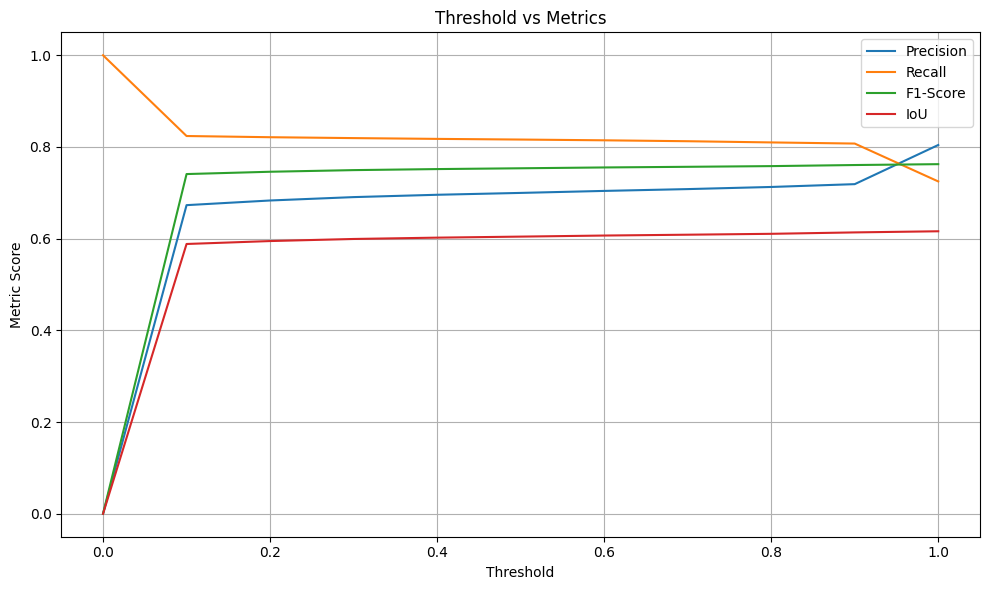

In [11]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from torchvision.utils import save_image
from ISNet import ISNet
from utils1.dataset_IRSTD1K import SirstDataset
from train_ISNet import Get_gradient_nopadding

# ------------------- Ayarlar -------------------
CHECKPOINT_PATH = 'result_backup/2025-06-19-07-38-55_ISNet_sir_AsymBi/checkpoint/Epoch-143_IoU-0.6042_nIoU-0.6062.pkl'  # 🔁 GÜNCELLE
SAVE_DIR = 'ISNet_test_output'
os.makedirs(SAVE_DIR, exist_ok=True)

# ------------------- Dataset -------------------
class DummyArgs:
    crop_size = 512
    base_size = 512

test_dataset = SirstDataset(DummyArgs(), mode='val')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ------------------- Model -------------------
model = torch.load(CHECKPOINT_PATH)
model.eval().cuda()
grad_fn = Get_gradient_nopadding().cuda()

# ------------------- Tahminler -------------------
all_preds, all_labels = [], []

with torch.no_grad():
    for i, (img, label, _) in enumerate(test_loader):
        img, label = img.cuda(), label[:, 0:1, :, :].cuda()
        grad_input = grad_fn(img)
        output, _ = model(img, grad_input)
        output = F.interpolate(output, size=img.shape[2:], mode='bilinear', align_corners=True)
        pred = torch.sigmoid(output)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())
        save_image(pred, os.path.join(SAVE_DIR, f'pred_{i:03d}.png'))

# ------------------- Metrikler -------------------
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

thresholds = np.linspace(0.0, 1.0, 11)
precisions, recalls, f1s, ious = [], [], [], []

for t in thresholds:
    pred_bin = (all_preds >= t).astype(np.uint8).reshape(-1)
    label_bin = (all_labels >= 0.5).astype(np.uint8).reshape(-1)

    precisions.append(precision_score(label_bin, pred_bin, zero_division=0))
    recalls.append(recall_score(label_bin, pred_bin, zero_division=0))
    f1s.append(f1_score(label_bin, pred_bin, zero_division=0))
    ious.append(jaccard_score(label_bin, pred_bin, zero_division=0))

# ------------------- Grafik -------------------
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1-Score')
plt.plot(thresholds, ious, label='IoU')
plt.xlabel('Threshold')
plt.ylabel('Metric Score')
plt.title('Threshold vs Metrics')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'threshold_metrics.png'))
print(f"✅ Metrik grafiği kaydedildi: {os.path.join(SAVE_DIR, 'threshold_metrics.png')}")

# ------------------- En iyi değerleri yazdır -------------------
best_idx = np.argmax(f1s)
print(f"\n🎯 En iyi F1-Score için threshold = {thresholds[best_idx]:.2f}")
print(f"Precision: {precisions[best_idx]:.4f}")
print(f"Recall   : {recalls[best_idx]:.4f}")
print(f"F1-Score : {f1s[best_idx]:.4f}")
print(f"IoU      : {ious[best_idx]:.4f}")


✅ Grafikler kaydedildi: 'isnet_loss_curve.png', 'isnet_miou_curve.png'


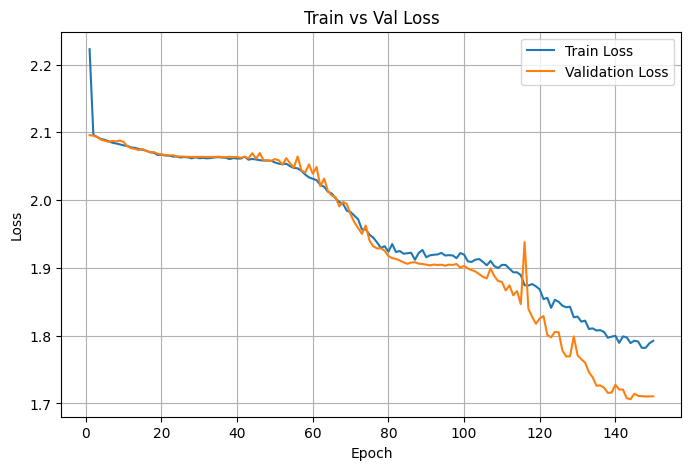

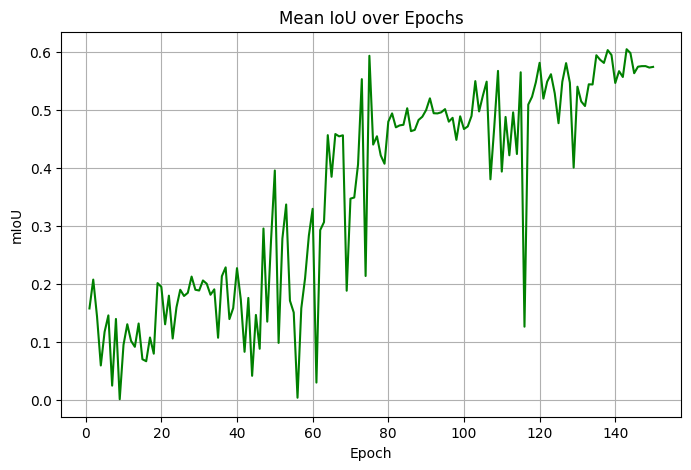

In [16]:
#%pip install tensorboard
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# TensorBoard log dosyası
event_path = 'result_backup/2025-06-19-07-38-55_ISNet_sir_AsymBi/events.out.tfevents.1750318735.9a5d6592424a'
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# --- Loss Grafiği ---
train_loss = event_acc.Scalars("Losses/train_loss")
val_loss = event_acc.Scalars("Losses/eval_loss")

epochs = [x.step for x in train_loss]
train_values = [x.value for x in train_loss]
val_values = [x.value for x in val_loss]

plt.figure(figsize=(8,5))
plt.plot(epochs, train_values, label='Train Loss')
plt.plot(epochs, val_values, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.grid(True)
plt.savefig("isnet_loss_curve.png")


# --- IoU (mIoU) Grafiği ---
miou = event_acc.Scalars("Eval/IoU")
miou_epochs = [x.step for x in miou]
miou_values = [x.value for x in miou]

plt.figure(figsize=(8,5))
plt.plot(miou_epochs, miou_values, label='mIoU', color='green')
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.title("Mean IoU over Epochs")
plt.grid(True)
plt.savefig("isnet_miou_curve.png")


print("✅ Grafikler kaydedildi: 'isnet_loss_curve.png', 'isnet_miou_curve.png'")



In [18]:
!zip -r /content/colab_backup.zip /content/ISNet

from google.colab import files
files.download("/content/colab_backup.zip")


Görüntülenen çıkış son 5000 satıra kısaltıldı.
  adding: content/ISNet/sirst-master/__MACOSX/sirst-master/masks/._Misc_303_pixels0.png (deflated 36%)
  adding: content/ISNet/sirst-master/__MACOSX/sirst-master/masks/._Misc_399.xml (deflated 36%)
  adding: content/ISNet/sirst-master/__MACOSX/sirst-master/masks/._Misc_101_pixels0.png (deflated 36%)
  adding: content/ISNet/sirst-master/__MACOSX/sirst-master/masks/._Misc_297_pixels0.png (deflated 36%)
  adding: content/ISNet/sirst-master/__MACOSX/sirst-master/masks/._Misc_174_pixels0.png (deflated 36%)
  adding: content/ISNet/sirst-master/__MACOSX/sirst-master/masks/._Misc_348_pixels0.png (deflated 36%)
  adding: content/ISNet/sirst-master/__MACOSX/sirst-master/masks/._Misc_254.xml (deflated 36%)
  adding: content/ISNet/sirst-master/__MACOSX/sirst-master/masks/._Misc_382.xml (deflated 36%)
  adding: content/ISNet/sirst-master/__MACOSX/sirst-master/masks/._Misc_288_pixels0.png (deflated 36%)
  adding: content/ISNet/sirst-master/__MACOSX/sirs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>